**Projet 10: Réaliser une application de recommandation de contenu** 



> "View" > "Table of contents" pour voir le plan du notebook

# 1. Imports et paramétrages

## 1.1 Installation et import des librairies

In [1]:
!pip install "numpy<2.0"

In [2]:
!pip install progressbar pandas matplotlib scikit-learn missingno tqdm mlflow

In [3]:
!pip install scikit-surprise

In [4]:
# Manipulation et Analyse de Données
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualisation de Données
import matplotlib.pyplot as plt
import missingno as msno
import mlflow

# Barre de Progression
import progressbar
from tqdm import tqdm


# Gestion du Système d'Exploitation
import os
import json


# Librairie Surprise (Systèmes de Recommandation)
from surprise import Reader, Dataset
# from surprise.model_selection import train_test_split, cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic
from surprise import SVD
from surprise import Dataset, Reader


# Métriques de Similarité (Scikit-learn)
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Génération de Nombres Aléatoires
import random

In [5]:
pip freeze

alembic==1.15.2
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.3.0
babel==2.17.0
beautifulsoup4==4.13.4
bleach==6.2.0
blinker==1.9.0
cachetools==5.5.2
certifi==2025.4.26
cffi==1.17.1
charset-normalizer==3.4.2
click==8.2.0
cloudpickle==3.1.1
colorama==0.4.6
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
databricks-sdk==0.53.0
debugpy==1.8.14
decorator==5.2.1
defusedxml==0.7.1
Deprecated==1.2.18
docker==7.1.0
executing==2.2.0
fastapi==0.115.12
fastjsonschema==2.21.1
Flask==3.1.1
fonttools==4.57.0
fqdn==1.5.1
gitdb==4.0.12
GitPython==3.1.44
google-auth==2.40.1
graphene==3.4.3
graphql-core==3.2.6
graphql-relay==3.2.0
greenlet==3.2.2
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.10
importlib_metadata==8.6.1
ipykernel==6.29.5
ipython==9.2.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.7
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.5.0
json5==0.12.0
jsonpointer==3

## 1.2 Data

In [6]:
# On définit le nom de l'experience MLflow
mlflow.set_experiment("articles_recommendation")

<Experiment: artifact_location='file:///C:/Users/flore/Openclassrooms/Projet%2010/mlruns/105242366599690493', creation_time=1747411180989, experiment_id='105242366599690493', last_update_time=1747411180989, lifecycle_stage='active', name='articles_recommendation', tags={}>

In [7]:
directory = 'C:/Users/flore/Openclassrooms/Projet 10/inputs/'
filename = "articles_metadata.csv"
path = os.path.join(directory, filename)

articles_metadata = pd.read_csv(path, decimal=".", low_memory=False)

In [8]:
filename = "articles_embeddings.pickle"
path = os.path.join(directory, filename)
embeddings = pd.read_pickle(path)

In [9]:
directory = 'C:/Users/flore/Openclassrooms/Projet 10/inputs/clicks'
filename = "clicks_hour_087.csv"
path = os.path.join(directory, filename)

clicks_hour_087 = pd.read_csv(path, decimal=".", low_memory=False)

## 1.3 Fonctions

In [10]:
def mean_similarity_score(recommender, user_history, recommendations):
    """
    Évalue la moyenne des similarités entre les articles recommandés et l'historique utilisateur.
    """
    sim_matrix = recommender.similarity_matrix
    
    # Ne garder que les similarités entre les recommandations et l'historique
    scores = []
    for rec in recommendations['click_article_id']:
        for hist in user_history:
            if rec in sim_matrix.columns and hist in sim_matrix.index:
                scores.append(sim_matrix.at[hist, rec])

    # print("Nb colonnes dans sim_matrix :", len(sim_matrix.columns))
    # print("Quelques IDs dans sim_matrix :", list(sim_matrix.columns[:5]))
    
    # print("Quelques articles recommandés :", recommendations_df['click_article_id'].tolist())
    # print("Articles recommandés présents dans article_embeddings :", [aid for aid in recommendations_df['click_article_id'] if aid in article_embeddings])
    return np.mean(scores) if scores else "erreur"

Fonction d’interface intermédiaire compatible avec evaluate_precision_recall_at_k, qui transforme user_id + train_articles en un vecteur utilisateur, puis appelle recommend_articles.

In [11]:
def recommendations_fn(user_id, train_articles, k):
    """
    Génère une liste de recommandations d'articles pour un utilisateur donné,
    en se basant sur les articles qu'il a lus (train_articles) via un filtrage basé sur le contenu.

    Paramètres :
    ----------
    user_id : str or int
        L'identifiant de l'utilisateur.
    train_articles : list
        La liste des IDs des articles cliqués par l'utilisateur (hors test).
    k : int
        Le nombre de recommandations à retourner.

    Retour :
    -------
    list
        Une liste des k articles recommandés (article_id), triés par similarité décroissante.
    """
    
    # Moyenne des embeddings des articles cliqués (train_articles)
    vectors = [article_embeddings[aid] for aid in train_articles if aid in article_embeddings]
    if not vectors:
        return []  # Aucun article recommandable
    user_vector = np.mean(vectors, axis=0)

    # Appel à ta fonction existante
    recommended = recommend_articles(user_vector, article_embeddings, top_k=k)
    return [aid for aid, _ in recommended]

In [12]:
def evaluate_precision_recall_at_k(clicks_df, get_user_profile_fn, article_embeddings, k=5, n_users=100):

    """
    Évalue Precision@K et Recall@K pour un système de recommandation.

    Args:
        clicks_df (pd.DataFrame): dataframe contenant 'user_id' et 'click_article_id'.
        recommendations_fn (function): fonction qui prend user_id et retourne top-K articles recommandés.
        k (int): nombre de recommandations à évaluer.

    Returns:
        dict: Moyenne des métriques 'precision' et 'recall'.
    """
    sampled_users = clicks_df["user_id"].drop_duplicates().sample(n=n_users, random_state=42)
    hits, total_relevant, total_recommended = 0, 0, 0

    for user_id in sampled_users:
        user_clicks = clicks_df[clicks_df["user_id"] == user_id]["click_article_id"].tolist()
        if len(user_clicks) < 2:
            continue  # Pas assez d'historique pour train/test split

        train_articles = user_clicks[:-1]
        test_article = user_clicks[-1]

        temp_df = pd.DataFrame({"user_id": [user_id] * len(train_articles), "click_article_id": train_articles, "click_timestamp": 1})
        user_vector = get_user_profile_fn(user_id, temp_df, article_embeddings)
        recommended = recommend_articles(user_vector, article_embeddings, top_k=k)

        if test_article in recommended:
            hits += 1
        total_relevant += 1
        total_recommended += k

    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0
    return precision, recall

## 1.4 Class

In [13]:
class ModelEvaluator:
    def __init__(self, train_df, test_df, k_list=[5, 10]):
        self.train_df = train_df
        self.test_df = test_df
        self.k_list = k_list

    def get_items_seen_by_user(self, df, user_id):
        return df[df['user_id'] == user_id]['click_article_id'].astype(int).tolist()

    def evaluate_model(self, model):
        results = {f'recall@{k}': [] for k in self.k_list}
        results.update({f'precision@{k}': [] for k in self.k_list})
        users = self.test_df['user_id'].unique()

        for user_id in tqdm(users, desc="Évaluation du modèle"):
            seen_train = self.get_items_seen_by_user(self.train_df, user_id)
            seen_test = self.get_items_seen_by_user(self.test_df, user_id)

            if not seen_test: # Évaluer uniquement s'il y a des interactions dans le test
                continue

            recommendations_df = model.recommend_items(user_id, items_to_ignore=seen_train, topn=max(self.k_list))
            recommended_items = [int(i) for i in recommendations_df['click_article_id'].tolist()]

            for k in self.k_list:
                recommended_k = recommended_items[:k]
                hits = len(set(recommended_k) & set(seen_test))
                recall = hits / len(seen_test) if seen_test else 0.0
                precision = hits / k if recommended_k else 0.0

                results[f'recall@{k}'].append(recall)
                results[f'precision@{k}'].append(precision)

        final_scores = {
            metric: round(sum(scores)/len(scores), 4) if scores else 0.0
            for metric, scores in results.items()
        }
        final_scores['modelName'] = model.get_model_name()
        return final_scores

In [14]:
    class ContentBasedRecommender:
        def __init__(self, article_features: pd.DataFrame):
            """
            article_features: DataFrame indexé par article_id, colonnes = features
            """
            # Pré-calcul de la matrice de similarité article-article
            self.article_features = article_features
            self.article_ids = article_features.index.tolist()
            self.similarity_matrix = pd.DataFrame(
                cosine_similarity(article_features),
                index=self.article_ids,
                columns=self.article_ids
            )
    
        def get_model_name(self):
            return "ContentBasedRecommender"
    
        def recommend_items(self, user_id, items_to_ignore=None, topn=10, user_history=None):
            if user_history is None or len(user_history) == 0:
                return pd.DataFrame(columns=['click_article_id', 'score'])
        
            # Normalisation des types d’IDs
            user_history = [int(i) for i in user_history]
            if items_to_ignore:
                items_to_ignore = [int(i) for i in items_to_ignore]
        
            # Agrégation des similarités
            similar_scores = self.similarity_matrix.loc[user_history].mean(axis=0)
        
            # if items_to_ignore:
            #     similar_scores = similar_scores.drop(index=items_to_ignore, errors='ignore')
        
            top_recs = similar_scores.sort_values(ascending=False).head(topn)
        
            return pd.DataFrame({
                'click_article_id': top_recs.index.astype(int), 
                'score': top_recs.values
            })

# 2. Quick Tour

Nous allons avoir 3 types de fichiers à explorer:

* **clicks.csv** (somme de tous les fichiers clicks_xxx.csv)
Données d’interactions utilisateur-article.
= Cœur du système de recommandation pour les deux approches. 
Colonne clé : click_article_id (équivaut à l’article_id ailleurs).
Colonnes utiles :
> * user_id : identifie l’utilisateur.
> * click_article_id : identifie l’article consulté.
> * click_timestamp : permet d’ordonner les clics → utile pour validation temporelle.

* **articles_metadata.csv**
Métadonnées utiles (type TF, IDF, analyse catégorie, durée de lecture…).
Sert surtout à enrichir les modèles content-based classiques (par ex., TF-IDF sur category_id, clustering des words_count).
Clé : article_id.

* **articles_embeddings.pickle**
Embeddings vectoriels de dimension 250, un vecteur par article.
Ordre implicite semble correspondre à article_id trié.
Mais pas encore de mapping direct explicite avec les article_id.
 Sert au Content-Based Filtering vectoriel, via cosine similarity.
On va devoir créer une correspondance {article_id ↔ index} à partir de articles_metadata trié par article_id.

In [15]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [16]:
articles_metadata.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


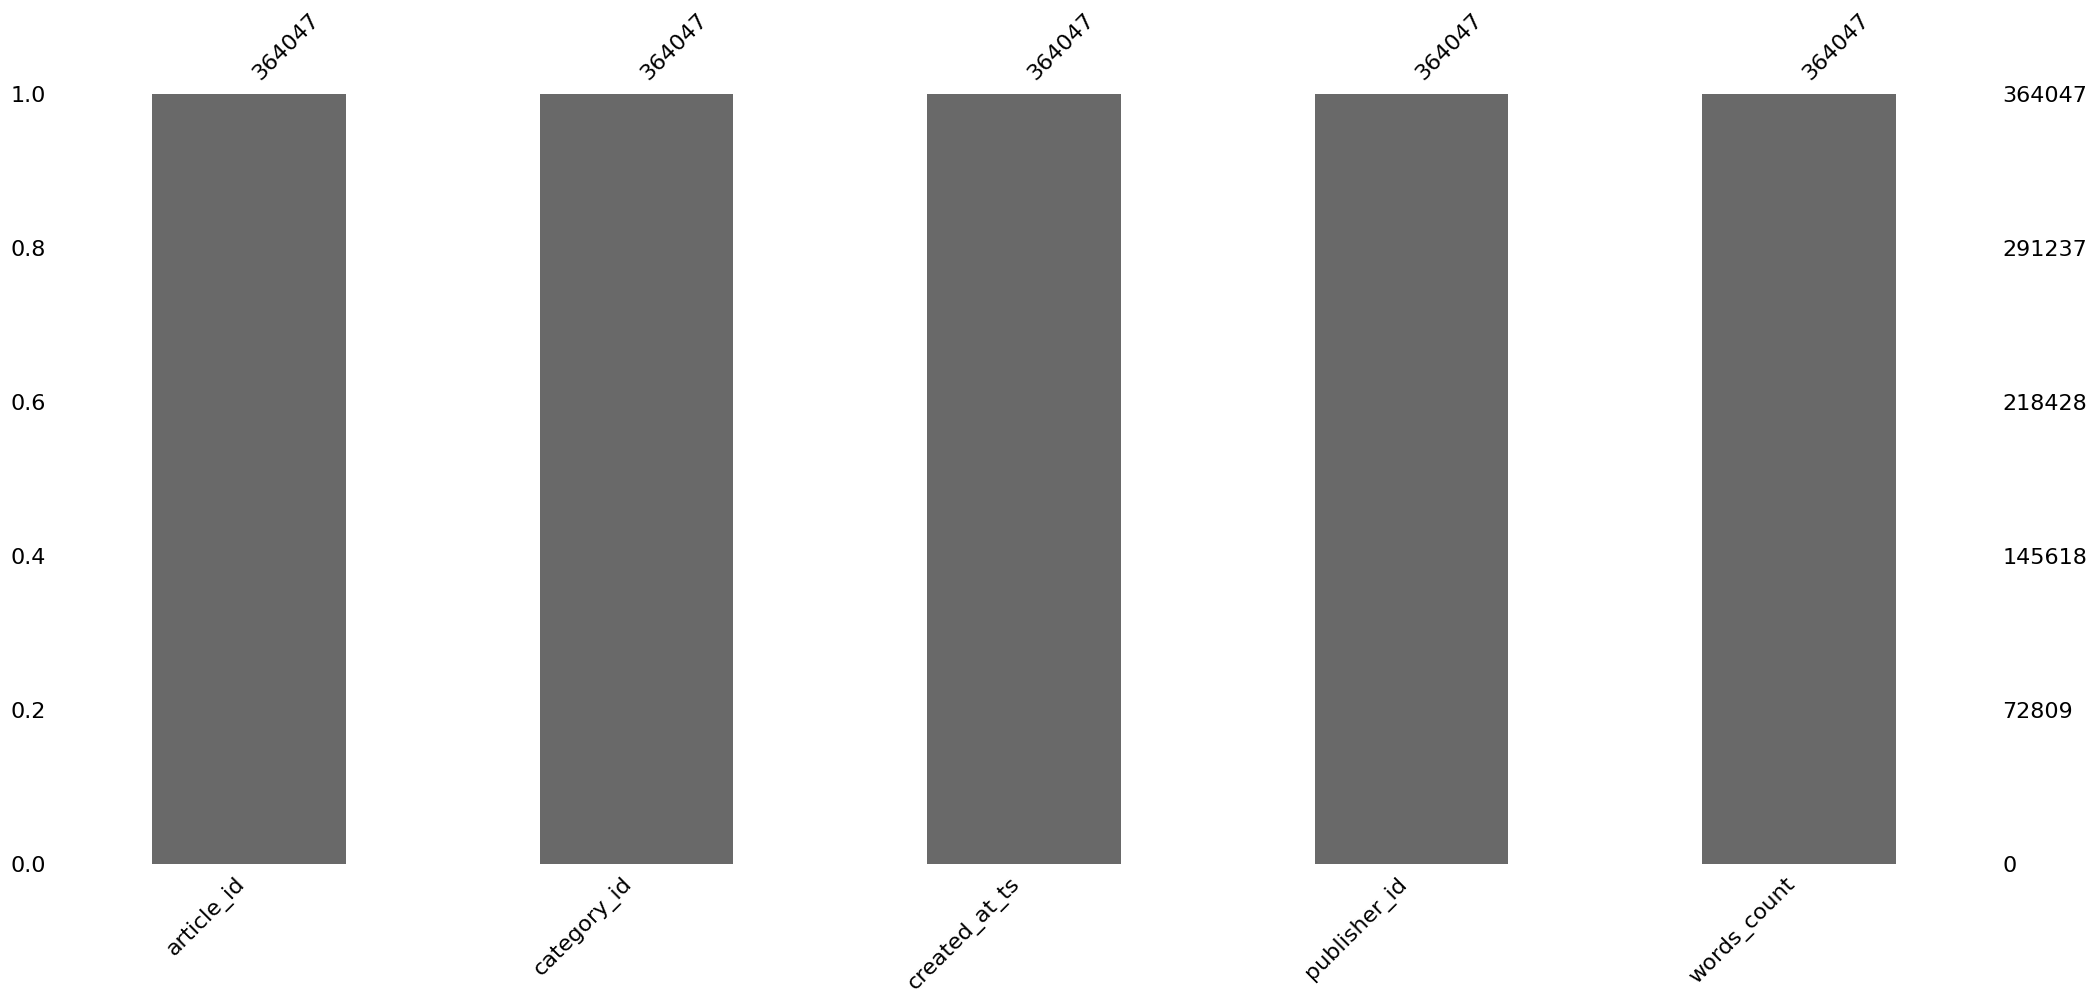

In [17]:
# Affichage du bar plot montrant le nombre de valeurs présentes et manquantes pour chaque colonne.
msno.bar(articles_metadata)
plt.show()

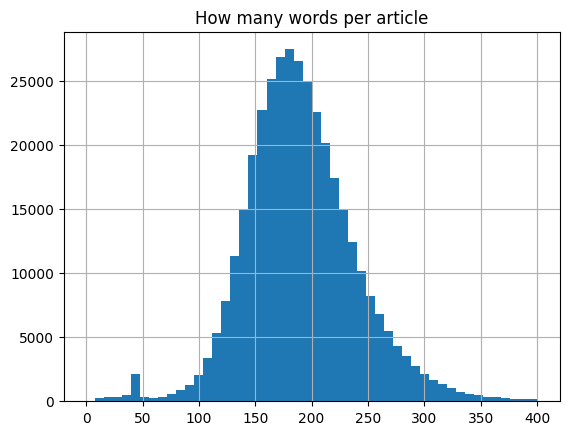

In [18]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

In [19]:
clicks_hour_087

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,57906,1507138581309087,1507138581000,2,47436,1507138584366,4,1,17,1,8,5
1,57906,1507138581309087,1507138581000,2,46180,1507138614366,4,1,17,1,8,5
2,132485,1507138583133088,1507138583000,7,129305,1507138628124,4,1,17,1,8,1
3,132485,1507138583133088,1507138583000,7,206112,1507138677588,4,1,17,1,8,1
4,132485,1507138583133088,1507138583000,7,166462,1507138707110,4,1,17,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14614,166393,1507142178379230,1507142178000,2,226681,1507142178636,2,3,20,1,5,7
14615,166393,1507142178379230,1507142178000,2,206730,1507142208636,2,3,20,1,5,7
14616,84161,1507142179142231,1507142179000,3,166462,1507142225147,4,1,17,1,25,1
14617,84161,1507142179142231,1507142179000,3,159762,1507142474081,4,1,17,1,25,1


In [20]:
clicks_hour_087.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,14619.000000,1.461900e+04,1.461900e+04,14619.000000,14619.000000,1.461900e+04,14619.000000,14619.000000,14619.000000,14619.000000,14619.000000,14619.000000
mean,99884.819276,1.507140e+15,1.507140e+12,3.771599,211030.202408,1.507142e+12,3.970928,1.455093,14.621110,1.266502,18.045147,1.845612
std,54674.549387,1.040038e+09,1.040039e+06,3.038432,81110.201437,9.324879e+06,0.240661,0.871528,5.594267,1.496558,7.156835,1.163138
min,10.000000,1.507139e+15,1.507139e+12,2.000000,1843.000000,1.507139e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,55286.000000,1.507139e+15,1.507139e+12,2.000000,159762.000000,1.507140e+12,4.000000,1.000000,17.000000,1.000000,13.000000,1.000000
50%,89454.000000,1.507140e+15,1.507140e+12,3.000000,207311.000000,1.507141e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000
75%,164945.000000,1.507141e+15,1.507141e+12,4.000000,285719.000000,1.507142e+12,4.000000,1.000000,17.000000,1.000000,25.000000,2.000000
max,166393.000000,1.507142e+15,1.507142e+12,30.000000,363967.000000,1.507559e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


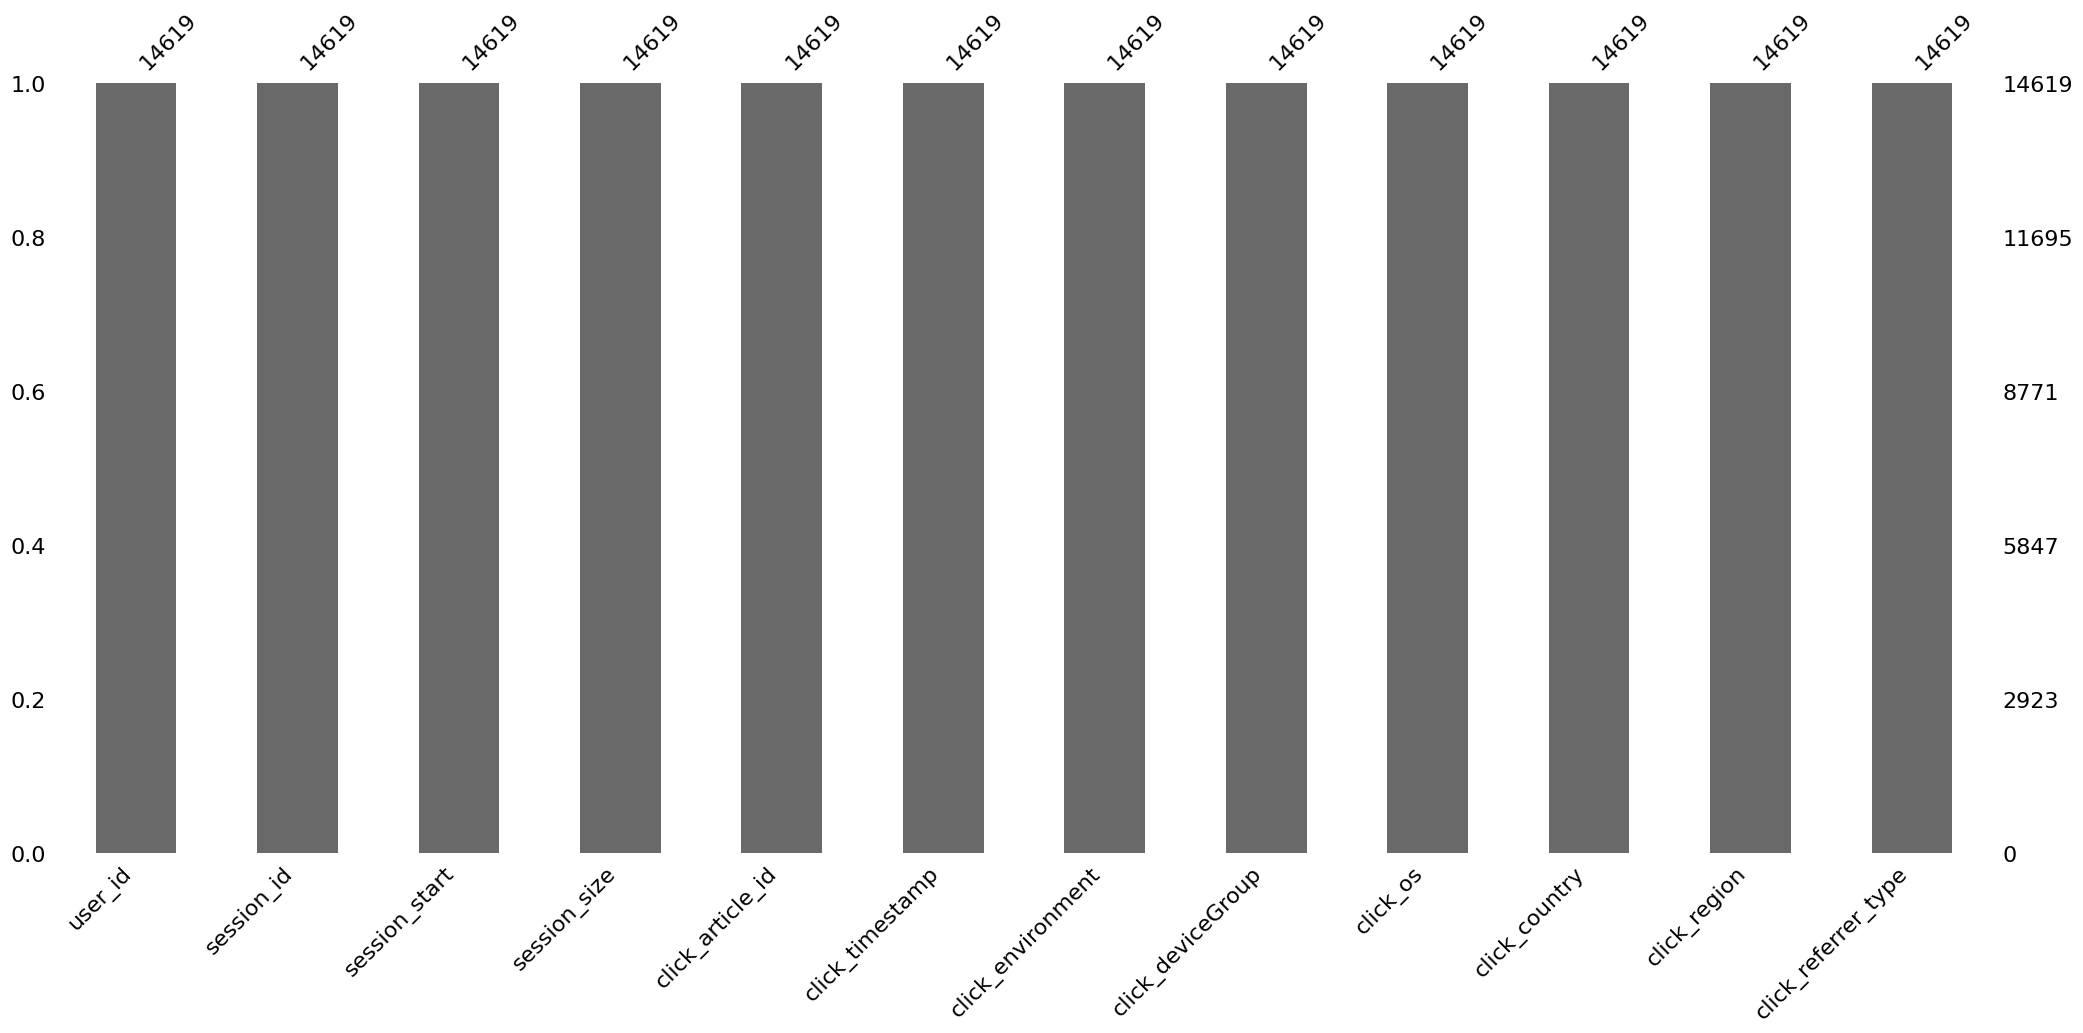

In [21]:
# Affichage du bar plot montrant le nombre de valeurs présentes et manquantes pour chaque colonne.
msno.bar(clicks_hour_087)
plt.show()


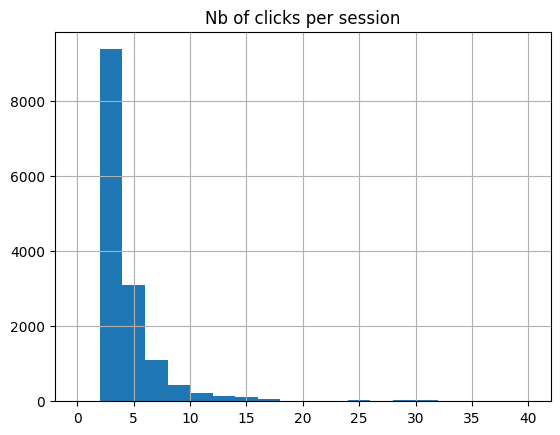

In [22]:
clicks_hour_087.session_size.hist(bins=20, range=(0,40))
plt.title('Nb of clicks per session');

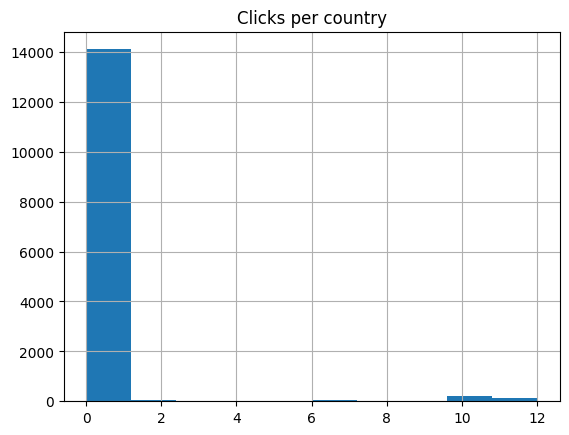

In [23]:
clicks_hour_087.click_country.hist(bins=10, range=(0,12))
plt.title('Clicks per country');

In [24]:
clicks_hour_087.loc[clicks_hour_087.user_id == 	166393]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
14614,166393,1507142178379230,1507142178000,2,226681,1507142178636,2,3,20,1,5,7
14615,166393,1507142178379230,1507142178000,2,206730,1507142208636,2,3,20,1,5,7


In [25]:
clicks_hour_087.loc[clicks_hour_087.session_id == 1507142178379230]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
14614,166393,1507142178379230,1507142178000,2,226681,1507142178636,2,3,20,1,5,7
14615,166393,1507142178379230,1507142178000,2,206730,1507142208636,2,3,20,1,5,7


# 3. Preparation des données

## 3.1 Mapping entre articles et embeddings

In [26]:
embeddings

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [27]:
embeddings.shape

(364047, 250)

In [28]:
articles_metadata["article_id"].size

364047

In [29]:
articles_metadata["article_id"].nunique()

364047

les "article_id" dans articles_metadata sont bien au meme nombre que les embeddings, on va donc créer un lien entre article_id et les embeddings

In [30]:
# Charger les contentId des articles
content_ids = articles_metadata["article_id"].sort_values().tolist()

# Créer un mapping contentId -> embedding
article_embeddings = dict(zip(content_ids, embeddings))

Crée un dictionnaire qui mappe chaque article_id (depuis articles_metadata.csv) à son index dans le tableau des embeddings.
Utile si on veut retrouver rapidement l'embedding d’un article

In [31]:
article_embeddings[364046]

array([-0.25713393, -0.9946313 ,  0.9837918 , -0.19097468, -0.95372003,
       -0.89382285,  0.70897424, -0.557027  ,  0.84684193, -0.11851932,
        0.77171886, -0.81077564,  0.81242806, -0.6977698 ,  0.5314953 ,
       -0.45345655,  0.02234515,  0.8769271 ,  0.94741654, -0.88085186,
       -0.4842552 , -0.6572001 ,  0.29745552, -0.40023822, -0.3645693 ,
        0.81184405, -0.919919  ,  0.27107313,  0.41475266, -0.20864615,
       -0.46743035, -0.68873554,  0.4420379 , -0.6123253 , -0.9383403 ,
       -0.54241943,  0.19822612,  0.7238798 , -0.40185034, -0.08931966,
       -0.66412914,  0.19056718,  0.877918  , -0.99238974,  0.39173394,
        0.3753621 , -0.79499745,  0.9167145 ,  0.13803585,  0.96597433,
       -0.71312815, -0.9195556 ,  0.78834224, -0.8112336 ,  0.5681865 ,
        0.8477787 , -0.08933286, -0.24795273,  0.9856869 , -0.44817355,
        0.96303916,  0.32898596, -0.89353883, -0.8172874 , -0.70405513,
       -0.70882314, -0.78378314,  0.58694714,  0.05717174,  0.48

In [32]:
# Convertir le dictionnaire en DataFrame

# Charger les article_ids
content_ids = articles_metadata["article_id"].sort_values().tolist()

# Vérifier que la taille correspond
assert len(content_ids) == len(embeddings), "Nombre d'IDs ≠ nombre d'embeddings"

# Créer un DataFrame indexé par article_id
article_features = pd.DataFrame(embeddings, index=content_ids)

# Nommer l'index (optionnel mais propre)
article_features.index.name = "article_id"

# Vérification
print(article_features.shape)
print(article_features.head())
print("Index type:", type(article_features.index[0]))
print("Feature type:", type(article_features.iloc[0, 0]))

(364047, 250)
                 0         1         2         3         4         5    \
article_id                                                               
0          -0.161183 -0.957233 -0.137944  0.050855  0.830055  0.901365   
1          -0.523216 -0.974058  0.738608  0.155234  0.626294  0.485297   
2          -0.619619 -0.972960 -0.207360 -0.128861  0.044748 -0.387535   
3          -0.740843 -0.975749  0.391698  0.641738 -0.268645  0.191745   
4          -0.279052 -0.972315  0.685374  0.113056  0.238315  0.271913   

                 6         7         8         9    ...       240       241  \
article_id                                          ...                       
0          -0.335148 -0.559561 -0.500603  0.165183  ...  0.321248  0.313999   
1          -0.715657 -0.897996 -0.359747  0.398246  ... -0.487843  0.823124   
2          -0.730477 -0.066126 -0.754899 -0.242004  ...  0.454756  0.473184   
3          -0.825593 -0.710591 -0.040099 -0.110514  ...  0.271535  0.036

## 3.2 Merge des .csv clicks en un seul fichier

In [33]:
clicks_filename = 'clicks.csv'
clicks_input_dir = "C:/Users/flore/Openclassrooms/Projet 10/inputs/clicks"
parent_dir = os.path.dirname(clicks_input_dir)
output_filepath = os.path.join(parent_dir, clicks_filename)


if not os.path.exists(output_filepath):
    all_csv_files = sorted(
        [
            os.path.join(clicks_input_dir, fname)
            for fname in os.listdir(clicks_input_dir)
            if fname.endswith(".csv")
        ]
    )
    print("Number of clicks csv found:", len(all_csv_files))

    list_of_dfs = [pd.read_csv(f, index_col=None, header=0) for f in all_csv_files]
    clicks = pd.concat(list_of_dfs, axis=0, ignore_index=True)
    clicks.to_csv(output_filepath, index=False)
    print(f"Combined clicks data saved to: {output_filepath}")
    
else:
    clicks = pd.read_csv(output_filepath)
    print(f"Loaded existing combined clicks data from: {output_filepath}")

print(clicks)

Loaded existing combined clicks data from: C:/Users/flore/Openclassrooms/Projet 10/inputs\clicks.csv
         user_id        session_id  session_start  session_size  \
0              0  1506825423271737  1506825423000             2   
1              0  1506825423271737  1506825423000             2   
2              1  1506825426267738  1506825426000             2   
3              1  1506825426267738  1506825426000             2   
4              2  1506825435299739  1506825435000             2   
...          ...               ...            ...           ...   
2988176    10051  1508211372158328  1508211372000             2   
2988177   322896  1508211376302329  1508211376000             2   
2988178   322896  1508211376302329  1508211376000             2   
2988179   123718  1508211379189330  1508211379000             2   
2988180   123718  1508211379189330  1508211379000             2   

         click_article_id  click_timestamp  click_environment  \
0                  157541    

In [34]:
print(clicks.columns)

Index(['user_id', 'session_id', 'session_start', 'session_size',
       'click_article_id', 'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
      dtype='object')


In [35]:
# Compter le nombre de clics par article
article_click_counts = clicks['click_article_id'].value_counts()

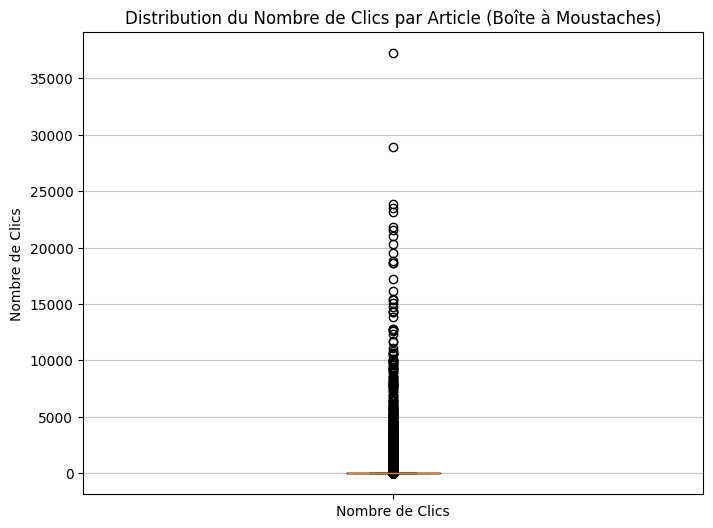

In [36]:
plt.figure(figsize=(8, 6))
plt.boxplot(article_click_counts )
plt.title('Distribution du Nombre de Clics par Article (Boîte à Moustaches)')
plt.ylabel('Nombre de Clics')
plt.xticks([1], ['Nombre de Clics'])
plt.grid(axis='y', alpha=0.75)
plt.show()

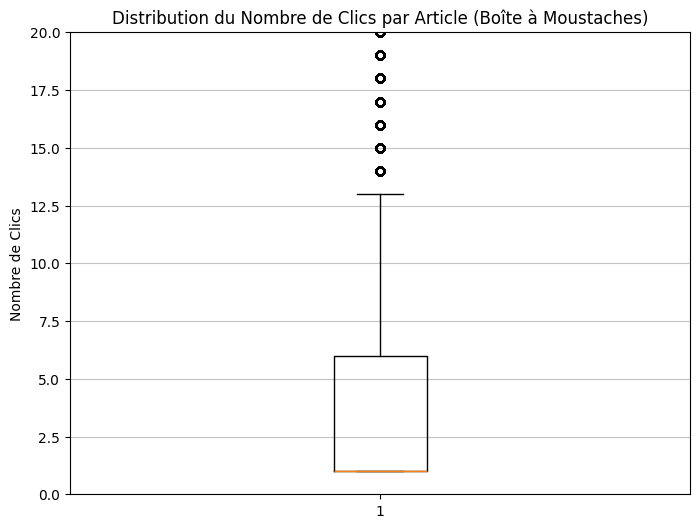

In [37]:
plt.figure(figsize=(8, 6))
plt.boxplot(article_click_counts )
plt.title('Distribution du Nombre de Clics par Article (Boîte à Moustaches)')
plt.ylabel('Nombre de Clics')
plt.ylim(0, 20)  # Limiter l'axe des y de 0 à 20
plt.grid(axis='y', alpha=0.75)
plt.show()

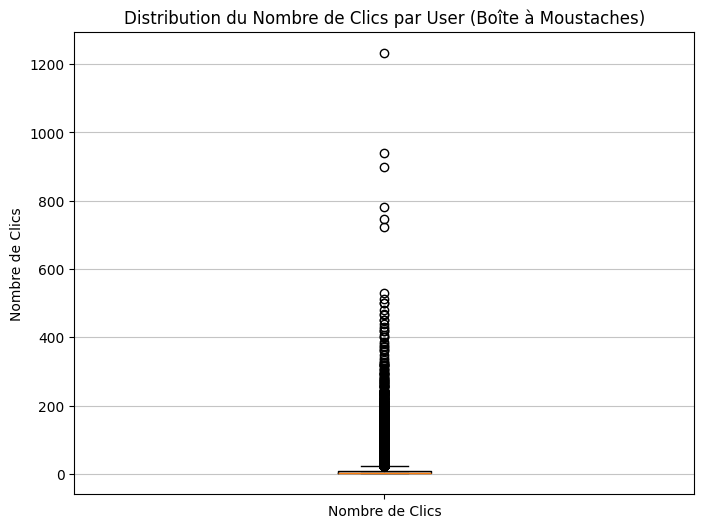

In [38]:
# Compter le nombre de clics par article
user_click_counts = clicks['user_id'].value_counts()

plt.figure(figsize=(8, 6))
plt.boxplot(user_click_counts )
plt.title('Distribution du Nombre de Clics par User (Boîte à Moustaches)')
plt.ylabel('Nombre de Clics')
plt.xticks([1], ['Nombre de Clics'])
plt.grid(axis='y', alpha=0.75)
plt.show()

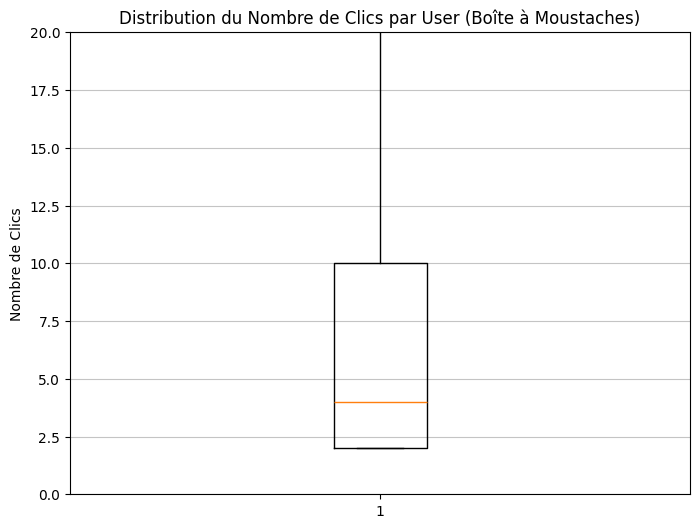

In [39]:
plt.figure(figsize=(8, 6))
plt.boxplot(user_click_counts )
plt.title('Distribution du Nombre de Clics par User (Boîte à Moustaches)')
plt.ylabel('Nombre de Clics')
plt.ylim(0, 20)  # Limiter l'axe des y de 0 à 20
plt.grid(axis='y', alpha=0.75)
plt.show()

## 3.3 Réduction et split du dataset en train-test

Pour des problématiques de mémoire et de temps de computation, nous allons réduire le dataset en filtrant sur les utilisateurs et les articles

Réduction des utilisateurs:

In [40]:
# Étape 1 : Comptage du nombre de clics par utilisateur
user_click_counts = clicks['user_id'].value_counts()

# Étape 2 : On garde uniquement les utilisateurs avec > 50 clics
filtered_users = user_click_counts[user_click_counts > 50].index

# Étape 3 : Échantillonnage de 1000 utilisateurs parmi les filtered_users pour accélérer encore plus les calculs
np.random.seed(42)
subset_users = np.random.choice(filtered_users, size=1000, replace=False)

# Étape 4 : Filtrer les données sur ces utilisateurs
filtered_clicks = clicks[clicks["user_id"].isin(subset_users)].copy()

In [41]:
print(f"Nb de users initiaux:",len(user_click_counts))
print(f"Nb de users après filtre (> 50clics):",len(filtered_users))
print(f"Nb de users finaux, apres sampling):",len(subset_users))

Nb de users initiaux: 322897
Nb de users après filtre (> 50clics): 6365
Nb de users finaux, apres sampling): 1000


In [42]:
subset_users[:10]

array([ 1076,  1465, 16081, 93849, 13231,  4837, 59193, 45061, 44812,
       43369], dtype=int64)

Réduction des articles:

In [43]:
# Compter le nombre de clics par article
article_counts = clicks["click_article_id"].value_counts()

# Garder uniquement les articles avec au moins 2 clics
filtered_articles = article_counts[article_counts > 5].index

In [44]:
print(f"Nb d'articles initiaux:",len(article_counts))
print(f"Nb d'articles après filtre:",len(filtered_articles))

Nb d'articles initiaux: 46033
Nb d'articles après filtre: 12106


In [45]:
# Garder seulement les lignes où l'article est populaire
articles_filtered_clicks = filtered_clicks[filtered_clicks["click_article_id"].isin(filtered_articles)].copy()

In [46]:
print(len(clicks))
print(len(articles_filtered_clicks))

2988181
82071


In [47]:
clicks_train, clicks_test = train_test_split(
    articles_filtered_clicks,
    stratify=articles_filtered_clicks['user_id'],
    test_size=0.2,
    random_state=42
)

print(f"# interactions dans le train set : {len(clicks_train)}")
print(f"# interactions dans le test set : {len(clicks_test)}")

# interactions dans le train set : 65656
# interactions dans le test set : 16415


In [48]:
clicks_train.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
1010190,61067,1507229759345396,1507229759000,2,25325,1507229830563,4,1,17,1,17,2
2385111,44289,1507837951110768,1507837951000,2,324553,1507838173800,4,1,17,1,25,2
2141242,54970,1507726665266300,1507726665000,8,236524,1507750770715,4,1,17,1,21,2
805886,83163,1507137792390819,1507137792000,3,199411,1507145761970,4,1,17,1,9,2
2869201,19882,1508161388411926,1508161388000,2,212234,1508161390290,4,3,2,1,24,7


Filtre pour ne conserver dans l'ensemble de test que des articles vus dans train:

In [49]:
# Conserver uniquement les articles présents dans le train
articles_train = set(clicks_train['click_article_id'].unique())
clicks_test = clicks_test[clicks_test['click_article_id'].isin(articles_train)].copy()

print(f"# interactions dans le test set filtré : {len(clicks_test)}")

# interactions dans le test set filtré : 15772


de la meme facon, reduire notre dataframe article_features avec uniquement les articles contenus dans les ensembles train et test:

In [50]:
unique_articles = articles_filtered_clicks['click_article_id'].unique()
len(unique_articles)

7796

In [51]:
article_features_filtered = article_features.loc[unique_articles]
len(article_features_filtered)

7796

outputs pour la fonction: 
* article_features.pkl
* user_history.json sur la base des 1000 utilisateurs sélectionnés et les ensembles de train et test

In [52]:
# Chemin de destination
output_path = r"C:\Users\flore\Openclassrooms\Projet 10\azure_function\article_features.pkl"
# Sauvegarde au format pickle
article_features_filtered.to_pickle(output_path)

In [53]:
output_path = r"C:\Users\flore\Openclassrooms\Projet 10\azure_function\user_history.json"

# Dictionnaire des historiques utilisateur
user_history_dict = {}

for user_id in subset_users:
    history = articles_filtered_clicks[articles_filtered_clicks['user_id'] == user_id]['click_article_id'].tolist()
    if history:  # On ajoute seulement si l'utilisateur a un historique
        user_history_dict[str(user_id)] = history  # Clés en string pour compatibilité JSON

# Sauvegarde au format JSON
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(user_history_dict, f, indent=2)

print(f"Fichier enregistré sous : {output_path}")

Fichier enregistré sous : C:\Users\flore\Openclassrooms\Projet 10\azure_function\user_history.json


# 4. Baseline: Popularité

In [54]:
class PopularityRecommender:

    def __init__(self, train_df):
        self.train_df = train_df
        self.popularity_rank = self._build_popularity_rank()

    def _build_popularity_rank(self):
        article_counts = self.train_df["click_article_id"].value_counts().reset_index()
        article_counts.columns = ['click_article_id', 'score']
        return article_counts

    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Recommandation des articles les plus populaires non encore vus
        popular_items = self.popularity_rank[
            ~self.popularity_rank['click_article_id'].isin(items_to_ignore)
        ].sort_values('score', ascending=False).head(topn)
        
        return popular_items.reset_index(drop=True)

    def get_model_name(self):
        return "Most Popular"

In [55]:
popularity_model = PopularityRecommender(clicks_train)
evaluator = ModelEvaluator(clicks_train, clicks_test, k_list=[5, 10])
results = evaluator.evaluate_model(popularity_model)

print("Résultats de la baseline 'Most Popular' :")
print(results)

Évaluation du modèle: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 955.63it/s]

Résultats de la baseline 'Most Popular' :
{'recall@5': 0.0384, 'recall@10': 0.064, 'precision@5': 0.1136, 'precision@10': 0.0946, 'modelName': 'Most Popular'}


In [56]:
# Top 10 des articles les plus populaires
top_articles = popularity_model.popularity_rank.head(10)
print("Top 10 des articles les plus populaires :")
print(top_articles)

Top 10 des articles les plus populaires :
   click_article_id  score
0            160974    433
1            272143    431
2            336221    377
3            336223    315
4            123909    305
5            331116    286
6            234698    281
7            272660    270
8            183176    264
9             96210    263


In [57]:
with mlflow.start_run(run_name="popularité"):
    user_id = 59193
    
    # Historique utilisateur
    seen_articles = popularity_model.train_df[popularity_model.train_df['user_id'] == user_id]['click_article_id'].tolist()
    
    # Recommandations popularité
    recommendations = popularity_model.recommend_items(user_id=user_id, items_to_ignore=seen_articles, topn=10)
    content_model = ContentBasedRecommender(article_features_filtered)
    
    print(f"Articles recommandés à l'utilisateur {user_id} (popularity-based):")
    print(recommendations)
    
    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)


Articles recommandés à l'utilisateur 59193 (popularity-based):
   click_article_id  score
0            336223    315
1            123909    305
2            331116    286
3            234698    281
4             96210    263
5            199198    238
6            336254    229
7            235616    228
8            336245    224
9            289003    215

Score moyen de similarité entre recommandations et historique : 0.2351


# 5. Content-Based Filtering

## 5.1. Représentation de l'utilisateur

Option A : Moyenne des embeddings des articles qu'il a lus

In [58]:
def get_user_profile_avg(user_id, clicks_df, article_embeddings):
    # Articles cliqués par l'utilisateur
    user_clicks = clicks_df[clicks_df["user_id"] == user_id]["click_article_id"]
    
    vectors = [article_embeddings[aid] for aid in user_clicks if aid in article_embeddings]
    
    if not vectors:
        return None  # Aucun embedding dispo
    return np.mean(vectors, axis=0)

Option B: Moyenne pondérée par récence

In [59]:
def get_user_profile_weighted(user_id, clicks_df, article_embeddings):
    user_clicks = clicks_df[clicks_df["user_id"] == user_id].sort_values("click_timestamp")
    vectors = []
    weights = []
    for i, row in user_clicks.iterrows():
        aid = row["click_article_id"]
        if aid in article_embeddings:
            vectors.append(article_embeddings[aid])
            weights.append(1.0 / (1 + (clicks_df["click_timestamp"].max() - row["click_timestamp"])))
    if not vectors:
        return None
    return np.average(vectors, axis=0, weights=weights)

## 5.2 Calculer la similarité avec tous les articles

Reco

In [60]:
# def recommend_articles(user_vector, article_embeddings, top_k=10):
#     """
#     Donne les top_k articles les plus similaires à un vecteur utilisateur donné.

#     Params:
#         user_vector: np.array de taille (250,)
#         article_embeddings: dict {article_id: embedding (np.array)}
#         top_k: nombre de recommandations à retourner

#     Returns:
#         Liste de tuples (article_id, similarité), triée par ordre décroissant de similarité
#     """
#     article_ids = list(article_embeddings.keys())
#     article_vectors = np.array([article_embeddings[aid] for aid in article_ids])

#     # Reshape user_vector pour correspondre à (1, 250)
#     user_vector = user_vector.reshape(1, -1)

#     # Calcul de similarité cosinus
#     similarities = cosine_similarity(user_vector, article_vectors)[0]  # shape: (num_articles,)

#     # Associer chaque article à sa similarité
#     scored_articles = list(zip(article_ids, similarities))

#     # Trier par similarité décroissante
#     scored_articles.sort(key=lambda x: x[1], reverse=True)

#     return scored_articles[:top_k]

In [61]:
def recommend_articles(user_vector, article_embeddings, top_k=10, allowed_article_ids=None):
    """
    Donne les top_k articles les plus similaires à un vecteur utilisateur donné.

    Params:
        user_vector: np.array de taille (250,)
        article_embeddings: dict {article_id: embedding (np.array)}
        top_k: nombre de recommandations à retourner

    Returns:
        Liste de tuples (article_id, similarité), triée par ordre décroissant de similarité
    """
    if allowed_article_ids is not None:
        article_ids = [aid for aid in article_embeddings.keys() if aid in allowed_article_ids]
    else:
        article_ids = list(article_embeddings.keys())
        
    article_vectors = np.array([article_embeddings[aid] for aid in article_ids])
    user_vector = user_vector.reshape(1, -1)

    similarities = cosine_similarity(user_vector, article_vectors)[0]
    scored_articles = list(zip(article_ids, similarities))
    scored_articles.sort(key=lambda x: x[1], reverse=True)

    return scored_articles[:top_k]

In [62]:
with mlflow.start_run(run_name="content_based_filtering_avg"):
    
    user_id = 59193
    # Étape 1 : Construction du vecteur utilisateur (moyenne des embeddings des articles lus)
    user_vector = get_user_profile_avg(user_id, clicks, article_embeddings)
    
    # Étape 2 : Recommandation
    allowed_ids = set(content_model.similarity_matrix.index)
    recommendations = recommend_articles(user_vector, article_embeddings, top_k=10, allowed_article_ids=allowed_ids)
    
    for article_id, score in recommendations:
        print(f"Article {article_id} - Similarité : {score:.3f}")
    
    # Conversion en DataFrame pour être compatible avec mean_similarity_score
    recommendations_df = pd.DataFrame(recommendations, columns=["click_article_id", "similarity_score"])
    content_model = ContentBasedRecommender(article_features_filtered)
    
    # Historique utilisateur
    seen_articles = popularity_model.train_df[popularity_model.train_df['user_id'] == user_id]['click_article_id'].tolist()
    
    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations_df)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)

Article 195037 - Similarité : 0.769
Article 124444 - Similarité : 0.763
Article 177749 - Similarité : 0.757
Article 217852 - Similarité : 0.753
Article 132566 - Similarité : 0.753
Article 362272 - Similarité : 0.751
Article 362558 - Similarité : 0.744
Article 129147 - Similarité : 0.736
Article 124337 - Similarité : 0.734
Article 123758 - Similarité : 0.734

Score moyen de similarité entre recommandations et historique : 0.3780


les articles recommandés sont assortis d'un score "similarité" qui correspond à la similarité entre l'article et le vecteur représentatif de l'utilisateur. Nous allons maintennant mesurer la similarité entre recos et historique de l'utilisateur

V2 avec un profil utilisateur pondéré (récence)

In [63]:
with mlflow.start_run(run_name="content_based_filtering_weighted"):


    # Étape 1 : Construction du vecteur utilisateur (moyenne des embeddings des articles lus, pondérée par récence)
    user_vector = get_user_profile_weighted(user_id, clicks, article_embeddings)
    
    # Étape 2 : Recommandation
    allowed_ids = set(content_model.similarity_matrix.index)
    recommendations = recommend_articles(user_vector, article_embeddings, top_k=10, allowed_article_ids=allowed_ids)
    
    # Affichage
    for article_id, score in recommendations:
        print(f"Article {article_id} - Similarité : {score:.3f}")

        # Conversion en DataFrame pour être compatible avec mean_similarity_score
    recommendations_df = pd.DataFrame(recommendations, columns=["click_article_id", "similarity_score"])
    
    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations_df)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)

Article 195037 - Similarité : 0.771
Article 124444 - Similarité : 0.762
Article 177749 - Similarité : 0.759
Article 217852 - Similarité : 0.755
Article 132566 - Similarité : 0.755
Article 362272 - Similarité : 0.753
Article 362558 - Similarité : 0.746
Article 129147 - Similarité : 0.735
Article 123301 - Similarité : 0.734
Article 123758 - Similarité : 0.734

Score moyen de similarité entre recommandations et historique : 0.3774


## 5.3 ContentBasedRecommender via matrice de similarité

Ici nous allons utiliser la class ContentBasedRocemmender.
Cette solution est déployée pour tenter de mesurer recall et precision@k de ContentBasedRecommender via matrice de similarité sur une multitude d'utilisateurs.

Cette solution gère la moyenne des embeddings des articles lus par l'utilisateur, implicitement via la mean() des similarités.
On utilise des vecteurs d’articles vs profil utilisateur (mean) mais dans cette version "classe",  l’accès au vecteur est délégué à un objet .get_article_vector(), ce qui permet (par ex) de recalculer les embeddings à la volée, les normaliser, ou ajouter des logs.

Etapes:
> * Pré-calcul de la matrice de similarité entre articles (cosine).
> * Recommandation par agrégation des similarités des articles vus par l’utilisateur.
> * Filtrage des articles déjà vus.
> * Fonction recommend_items() rapide et vectorisée.
> * Intégration dans un ModelEvaluator rapide.

In [64]:
cb_model = ContentBasedRecommender(article_features=article_features_filtered)
evaluator = ModelEvaluator(train_df=clicks_train, test_df=clicks_test, k_list=[5, 10])

results_cb = evaluator.evaluate_model(cb_model)
print(results_cb)

Évaluation du modèle: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1659.32it/s]

{'recall@5': 0.0, 'recall@10': 0.0, 'precision@5': 0.0, 'precision@10': 0.0, 'modelName': 'ContentBasedRecommender'}


In [65]:
with mlflow.start_run(run_name="content_based_filtering_matrix"):
    user_id = 59193 #clicks_test['user_id'].iloc[2]
    user_history = clicks_train[clicks_train['user_id'] == user_id]['click_article_id'].tolist()
    
    print(f"Articles vus en train par l'utilisateur {user_id} : {user_history}")
    
    recommendations = cb_model.recommend_items(
        user_id=user_id,
        items_to_ignore=user_history,
        topn=10,
        user_history=user_history
    )
    
    
    seen_test = clicks_test[clicks_test['user_id'] == user_id]['click_article_id'].tolist()
    
    # Articles en commun
    common = set(seen_test) & set(recommendations['click_article_id'].astype(int))
    print("Articles vus en test :", seen_test)
    print("Articles recommandés :", recommendations)
    print(len(common),f"Articles en commun   :", list(common))

    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)

Articles vus en train par l'utilisateur 59193 : [31520, 128988, 30389, 13579, 145166, 313504, 97546, 9690, 293432, 184091, 32292, 48409, 236969, 199197, 360959, 158646, 187445, 30083, 273473, 284583, 277107, 3598, 71500, 128623, 276946, 145772, 214283, 162655, 336220, 141281, 123757, 140772, 96244, 284844, 133160, 336221, 288435, 214322, 136156, 16087, 119197, 324823, 136101, 123826, 243256, 284773, 133112, 74722, 129364, 156560, 124751, 214744, 336801, 140450, 352901, 15653, 288741, 123614, 136768, 50569, 124350, 30714, 132631, 293513, 64346, 331314, 2628, 162107, 175476, 141517, 129305, 128707, 141956, 7694, 140824, 214600, 128957, 119102, 183176, 59867, 285101, 292552, 141004, 258446, 158536, 124228, 145692, 285333, 272143, 133141, 124734, 128710, 220042, 336286, 233595, 214631, 201815, 218183, 119117, 123559, 157478, 211722, 140971, 140515, 159762, 119107, 326732, 241954, 199207, 337438, 227557, 353847, 119192, 124194, 129004, 136610, 270228, 32750, 107272, 234128, 25325, 132801, 1

Check des articles réellement vus dans test par l'utilisateur:

In [66]:
user_history = [int(i) for i in clicks_train[clicks_train['user_id'] == user_id]['click_article_id'].unique()]
seen_test = [int(i) for i in clicks_test[clicks_test['user_id'] == user_id]['click_article_id'].unique()]

for article in seen_test:
    if article in cb_model.similarity_matrix.index:
        similarity_with_history = cb_model.similarity_matrix.loc[user_history, article].mean()
        print(f"Article {article} - Similarité moyenne avec l’historique : {similarity_with_history:.4f}")

Article 336223 - Similarité moyenne avec l’historique : 0.1961
Article 237580 - Similarité moyenne avec l’historique : 0.1599
Article 129424 - Similarité moyenne avec l’historique : 0.2872
Article 288484 - Similarité moyenne avec l’historique : 0.2673
Article 286077 - Similarité moyenne avec l’historique : 0.2919
Article 236613 - Similarité moyenne avec l’historique : 0.2488
Article 199844 - Similarité moyenne avec l’historique : 0.2907
Article 83841 - Similarité moyenne avec l’historique : 0.2279
Article 282875 - Similarité moyenne avec l’historique : 0.2088
Article 182469 - Similarité moyenne avec l’historique : 0.2737
Article 140324 - Similarité moyenne avec l’historique : 0.2429
Article 114440 - Similarité moyenne avec l’historique : 0.2201
Article 234698 - Similarité moyenne avec l’historique : 0.2000
Article 182394 - Similarité moyenne avec l’historique : 0.3212
Article 36394 - Similarité moyenne avec l’historique : 0.3249
Article 123758 - Similarité moyenne avec l’historique : 0

**Avantages :**

* Indépendance de l'utilisateur : Contrairement au filtrage collaboratif qui s'appuie sur les évaluations d'autres utilisateurs, le filtrage basé sur le contenu analyse uniquement les articles et le profil d'un seul utilisateur, simplifiant le processus et offrant des résultats plus fiables même avec peu d'utilisateurs.
* Transparence : Les recommandations sont basées sur les caractéristiques des articles, offrant une compréhension claire des raisons derrière les suggestions, contrairement au filtrage collaboratif qui repose sur des utilisateurs inconnus aux goûts similaires.
* Pas de Cold start : Les nouveaux articles peuvent être suggérés avant d'avoir été évalués par un grand nombre d'utilisateurs, ce qui n'est pas possible avec le filtrage collaboratif.

**Inconvénients :**

* Analyse de contenu limitée : Si le contenu ne contient pas suffisamment d'informations pour distinguer précisément les articles, les recommandations risquent d'être imprécises.
* Sur-spécialisation : Le filtrage basé sur le contenu offre peu de nouveauté car il doit faire correspondre les caractéristiques du profil de l'utilisateur avec les articles disponibles. Un système parfait pourrait ne jamais suggérer quelque chose d'inattendu ou de surprenant.

# 6. Memory-based Collaborative Filtering (avec Surprise)

## 6.1 Item-based KNN

Je rencontre des problème mémoire du fait du nombre trop important d'articles dans la base. 
De ce fait, nous allons exlure de l'analyse les articles peu cliqués de la base de données.

In [67]:
# # Compter le nombre de clics par article
# article_counts = clicks["click_article_id"].value_counts()

# # Garder uniquement les articles avec au moins 20 clics
# filtered_articles = article_counts[article_counts > 2].index

In [68]:
# print(f"Nb d'articles initiaux:",len(article_counts))
# print(f"Nb d'articles après filtre:",len(filtered_articles))

In [69]:
# # Garder seulement les lignes où l'article est populaire
# filtered_clicks = clicks[clicks["click_article_id"].isin(filtered_articles)].copy()

In [70]:
articles_filtered_clicks["rating"] = 1  

reader = Reader(rating_scale=(1, 1))
data = Dataset.load_from_df(articles_filtered_clicks[["user_id", "click_article_id", "rating"]], reader)
trainset = data.build_full_trainset()

In [71]:
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)

model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [72]:
with mlflow.start_run(run_name="item_based_KNN"):
    # Prédiction pour un utilisateur:
    user_id = 59193
    
    user_inner_id = trainset.to_inner_uid(user_id)
    user_ratings = model.get_neighbors(user_inner_id, k=10)
    
    # Convertir les inner IDs en vrais article_ids
    recommended_article_ids = [trainset.to_raw_iid(inner_id) for inner_id in user_ratings]
    
    print(f"Articles similaires recommandés (item-based): {recommended_article_ids}")
    
    # conversion des recos dans un DataFrame
    recommendations_df = pd.DataFrame({'click_article_id': recommended_article_ids})
    
    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations_df)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)

Articles similaires recommandés (item-based): [337763, 272660, 118180, 160974, 158536, 87173, 300470, 162655, 225463, 336429]

Score moyen de similarité entre recommandations et historique : 0.2324


## 6.2 User-based KNN

Même soucis de mémoire, cette fois-ci du fait du nombre trop important d'utilisateurs dans la base. 
De ce fait, nous allons exlure de l'analyse les utilisateurs qui ont le moins de clics.

In [73]:
# # Compter le nombre de clics par user
# user_click_counts = clicks['user_id'].value_counts()

# # Garder uniquement les articles avec au moins 20 clics
# filtered_users = user_click_counts[user_click_counts > 50].index

In [74]:
# print(f"Nb de users initiaux:",len(user_click_counts))
# print(f"Nb de users après filtre:",len(filtered_users))

In [75]:
# # Garder seulement les lignes où l'article est populaire
# filtered_clicks = clicks[clicks["user_id"].isin(filtered_users)].copy()

In [76]:
# pondérer par log du nombre de clics par utilisateur sur un article
articles_filtered_clicks["rating"] = 1  
click_counts = articles_filtered_clicks.groupby(['user_id', 'click_article_id']).size().reset_index(name='count')
click_counts['rating'] = click_counts['count'].apply(lambda x: np.log1p(x))

reader = Reader(rating_scale=(click_counts["rating"].min(), click_counts["rating"].max())) #échelle de notation définie dynamiquement
data = Dataset.load_from_df(click_counts[["user_id", "click_article_id", "rating"]], reader)
trainset = data.build_full_trainset()

In [77]:
sim_options = {'name': 'pearson', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

model.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [78]:
# user_ids_in_trainset = list(trainset._raw2inner_id_users.keys())
# random.seed(42)
# # Sélectionner aléatoirement 5 utilisateurs
# random_users = random.sample(user_ids_in_trainset, 5)
# random_users

In [79]:
# Recommandations pour un utilisateur
user_id = 59193

if user_id in trainset._raw2inner_id_users:
    user_inner_id = trainset.to_inner_uid(user_id)
    neighbors_inner_ids = model.get_neighbors(user_inner_id, k=10)
    neighbors = [trainset.to_raw_uid(inner_id) for inner_id in neighbors_inner_ids]
    print(f"Utilisateurs similaires (user_id) pour {user_id} : {neighbors}")
else:
    print("Utilisateur non présent dans le trainset filtré.")

Utilisateurs similaires (user_id) pour 59193 : [125733, 52875, 244, 338, 653, 1015, 1119, 1390, 1565, 1717]


Fonction pour recommander des articles à partir du modèle user-based

In [80]:
def get_top_n(model, trainset, user_id, n=10):
    # user_id = str(user_id_raw)

    # Vérifier que l'utilisateur est connu
    if user_id not in trainset._raw2inner_id_users:
        print("Utilisateur non présent dans le trainset.")
        return []

    inner_uid = trainset.to_inner_uid(user_id)

    # Obtenir tous les items que l'utilisateur n'a pas encore vus
    user_items = set([j for (j, _) in trainset.ur[inner_uid]])
    all_items = set(range(trainset.n_items))
    unseen_items = all_items - user_items

    predictions = []
    for inner_iid in unseen_items:
        pred = model.predict(user_id, trainset.to_raw_iid(inner_iid))
        predictions.append((trainset.to_raw_iid(inner_iid), pred.est))

    # Trier et renvoyer les meilleurs
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

In [81]:
top_articles

,click_article_id,score
0,160974,433
1,272143,431
2,336221,377
3,336223,315
4,123909,305
5,331116,286
6,234698,281
7,272660,270
8,183176,264
9,96210,263


In [82]:
with mlflow.start_run(run_name="user_based_KNN"):

    user_id = 59193
    
    top_articles = get_top_n(model, trainset, user_id, n=10)
    
    print(f"Utilisateur:",user_id)
    for article_id, score in top_articles:
        print(f"Article {article_id} - Score prédit : {score:.2f}")

    # conversion des recos dans un DataFrame
    recommendations_df = pd.DataFrame(top_articles, columns=['click_article_id', 'similarity_score'])
    
    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations_df)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)

Utilisateur: 59193
Article 263295 - Score prédit : 1.95
Article 263896 - Score prédit : 1.95
Article 264284 - Score prédit : 1.79
Article 264689 - Score prédit : 1.79
Article 264955 - Score prédit : 1.79
Article 39825 - Score prédit : 1.61
Article 263442 - Score prédit : 1.61
Article 263624 - Score prédit : 1.61
Article 263674 - Score prédit : 1.61
Article 264065 - Score prédit : 1.61

Score moyen de similarité entre recommandations et historique : 0.2275


## 6.3  Model based (SVD)

In [83]:
# # Construire les données pour Surprise:
# # Converti les clicks en format (user, item, rating)
# clicks_df = clicks.copy()
# # pondérer par log du nombre de clics par utilisateur sur un article
# clicks_df["rating"] = 1  
# click_counts = clicks_df.groupby(['user_id', 'click_article_id']).size().reset_index(name='count')
# click_counts['rating'] = click_counts['count'].apply(lambda x: np.log1p(x))

# reader = Reader(rating_scale=(click_counts["rating"].min(), click_counts["rating"].max())) #échelle de notation définie dynamiquement
# data = Dataset.load_from_df(click_counts[["user_id", "click_article_id", "rating"]], reader)

# trainset = data.build_full_trainset()

In [84]:
# Construire les données pour Surprise:
train_counts = clicks_train.groupby(['user_id', 'click_article_id']).size().reset_index(name='count')
# Pondération par log du nombre de clics par utilisateur sur un article
# train_counts['rating'] = train_counts['count'].apply(lambda x: np.log1p(x))
min_count = train_counts['count'].min()
max_count = train_counts['count'].max()
train_counts['rating'] = (train_counts['count'] - min_count) / (max_count - min_count)

reader = Reader(rating_scale=(train_counts["rating"].min(), train_counts["rating"].max())) #échelle de notation définie dynamiquement
data = Dataset.load_from_df(train_counts[["user_id", "click_article_id", "rating"]], reader)

# Construire le trainset (Surprise)
trainset = data.build_full_trainset()

Optimisation des hyperparamètres via Gridsearch

In [85]:
# param_grid = {'n_factors': [50, 100, 200],
#               'n_epochs': [20, 50],
#               'lr_all': [0.002, 0.005],
#               'reg_all': [0.02, 0.04]
#              }

# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'])#, cv=3)
# gs.fit(data)

# print("Meilleur score obtenu avec:")
# print(f"Param: ",gs.best_params['rmse'])
# print(f"Score: ",gs.best_score['rmse'])

In [86]:
# results_df = pd.DataFrame(gs.cv_results)

# # Afficher les colonnes pertinentes
# results_df[['params', 'mean_test_rmse', 'std_test_rmse', 'mean_test_mae', 'std_test_mae']]

In [87]:
# for index, row in results_df.iterrows():
#     print(f"Index: {index}")
#     print("Paramètres:")
#     for key, value in row['params'].items():
#         print(f"  {key}: {value}")
#     print(f"RMSE: {row['mean_test_rmse']:.4f}")
#     print(f"MAE: {row['mean_test_mae']:.4f}")
#     print("-" * 30)

paramètres choisis:

In [88]:
params = {'n_factors': 200,
              'n_epochs': 20,
              'lr_all': 0.002,
              'reg_all': 0.02
             }

In [89]:
svd_tuned = SVD(**params)
svd_tuned.fit(trainset)

Wrapper SVD
avec:
* train_df (ou clicks_train)
C’est un DataFrame Pandas, le jeu de données d'entraînement original.
Format : (user_id, click_article_id)
Utilisé pour :
> Voir les articles qu’un utilisateur a déjà vus
> Filtrer les interactions connues
> Évaluer les recommandations

* trainset
C’est un objet interne de Surprise créé par : trainset = data.build_full_trainset()
Format interne (avec encodage des IDs en inner_uid et inner_iid)
Utilisé par l’algorithme SVD().fit(...)
Il contient :
> La matrice utilisateur-article (avec les ratings, implicites ici)
> Les méthodes pour passer de user_id → inner_uid (et inversement)

In [90]:
class SVDRecommender:
    def __init__(self, model, trainset, train_df):
        self.model = model
        self.trainset = trainset
        self.train_df = train_df

    def recommend_items(self, user_id, items_to_ignore=None, topn=10):
        try:
            inner_uid = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return pd.DataFrame(columns=['click_article_id', 'score'])

        user_items = set(j for (j, _) in self.trainset.ur[inner_uid])
        all_items = set(range(self.trainset.n_items))
        unseen_items = all_items - user_items

        predictions = []
        for inner_iid in unseen_items:
            raw_iid = self.trainset.to_raw_iid(inner_iid)
            if items_to_ignore and int(raw_iid) in items_to_ignore:
                continue
            pred = self.model.predict(user_id, raw_iid)
            predictions.append((int(raw_iid), pred.est))

        top_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:topn]
        return pd.DataFrame(top_preds, columns=['click_article_id', 'score'])

    def get_model_name(self):
        return "SVD"

In [91]:
svd_wrapper_tuned = SVDRecommender(svd_tuned, trainset, train_df=clicks_train)

evaluator = ModelEvaluator(train_df=clicks_train, test_df=clicks_test, k_list=[5, 10])
results_tuned = evaluator.evaluate_model(svd_wrapper_tuned)
print(results_tuned)

Évaluation du modèle: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.49it/s]

{'recall@5': 0.0006, 'recall@10': 0.0009, 'precision@5': 0.0018, 'precision@10': 0.0016, 'modelName': 'SVD'}


In [92]:
uid = 59193 
print("Articles vus en test :", clicks_test[clicks_test['user_id'] == uid]['click_article_id'].tolist())

svd_wrapper_tuned.recommend_items(uid, items_to_ignore=clicks_train[clicks_train['user_id'] == uid]['click_article_id'].tolist(), topn=10)

Articles vus en test : [336223, 237580, 129424, 288484, 286077, 236613, 199844, 83841, 282875, 182469, 140324, 114440, 234698, 182394, 36394, 123758, 119600, 205832, 285045, 216380, 141414, 156619, 118618, 32655, 129165, 120967, 118753, 234291, 141113, 284178, 331737, 308156, 298820, 187065, 114562, 157702, 303658, 313431, 141004, 233478, 3240, 362914, 235854, 118856, 123909, 87228, 83565, 237612, 166430, 95977, 118514, 96391, 96152, 129158, 256117, 140985, 286108, 284191, 351517, 140907, 123909, 140451, 124353, 113978, 119534]


,click_article_id,score
0,79844,0.372190
1,149613,0.369072
2,300756,0.365351
3,84010,0.359794
4,97538,0.353357
5,164575,0.351498
6,66349,0.349986
7,277278,0.347753
8,354099,0.341792
9,198468,0.336335


In [93]:
with mlflow.start_run(run_name="model_based_SVD"):

    uid = 59193 
    
    # Liste des articles vus en test
    seen_test = clicks_test[clicks_test['user_id'] == uid]['click_article_id'].tolist()
    
    # Liste des articles recommandés par le modèle
    recommended = svd_wrapper_tuned.recommend_items(
        uid,
        items_to_ignore=clicks_train[clicks_train['user_id'] == uid]['click_article_id'].tolist(),
        topn=10
    )['click_article_id'].tolist()
    
    # Articles en commun
    common = set(seen_test) & set(recommended)
    
    print("Articles vus en test :", seen_test)
    print("Articles recommandés :", recommended)
    print("Articles en commun   :", list(common))
    
    # conversion des recos dans un DataFrame
    recommendations_df = pd.DataFrame({'click_article_id': recommended})
    
    # Score moyen de similarité avec historique utilisateur
    score = mean_similarity_score(content_model, seen_articles, recommendations_df)
    print(f"\nScore moyen de similarité entre recommandations et historique : {score:.4f}")

    # Log des métriques
    mlflow.log_metric("Similarité_histo", score)

Articles vus en test : [336223, 237580, 129424, 288484, 286077, 236613, 199844, 83841, 282875, 182469, 140324, 114440, 234698, 182394, 36394, 123758, 119600, 205832, 285045, 216380, 141414, 156619, 118618, 32655, 129165, 120967, 118753, 234291, 141113, 284178, 331737, 308156, 298820, 187065, 114562, 157702, 303658, 313431, 141004, 233478, 3240, 362914, 235854, 118856, 123909, 87228, 83565, 237612, 166430, 95977, 118514, 96391, 96152, 129158, 256117, 140985, 286108, 284191, 351517, 140907, 123909, 140451, 124353, 113978, 119534]
Articles recommandés : [79844, 149613, 300756, 84010, 97538, 164575, 66349, 277278, 354099, 198468]
Articles en commun   : []

Score moyen de similarité entre recommandations et historique : 0.2025


# Conclusion